In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO


In [72]:
records = []
for record in SeqIO.parse("sequence.fasta", "fasta"):
    records.append(str(record.seq))

In [73]:
def split_sequence(sequence,length):
    return [sequence[i:i+length] for i in range(0, len(sequence), length)]
sequence=records[0]
segment_length=45
segments=split_sequence(sequence, segment_length)
df=pd.DataFrame(segments, columns=['segment'])
df.head()

,segment
0,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
1,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
2,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
3,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
4,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


In [74]:
df['Sequence_length']=df['segment'].apply(len)
df['Sequence_length'].describe()

count    64.000000
mean     44.828125
std       1.375000
min      34.000000
25%      45.000000
50%      45.000000
75%      45.000000
max      45.000000
Name: Sequence_length, dtype: float64

c:\users\hp\appdata\local\programs\python\python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\users\hp\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


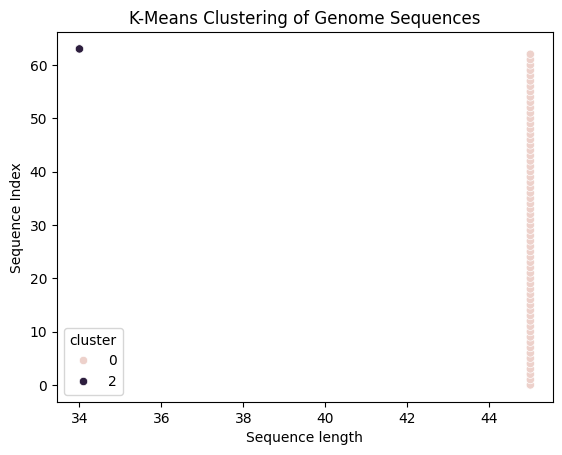

In [75]:
X=df['Sequence_length'].values.reshape(-1,1)
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
scaler=StandardScaler()
X_scaled=scaler.fit_transform(X)
kmeans=KMeans(n_clusters=3, random_state=42)
df['cluster']=kmeans.fit_predict(X_scaled)

sns.scatterplot(data=df, x='Sequence_length', y=df.index, hue='cluster')
plt.xlabel('Sequence length')
plt.ylabel('Sequence Index')
plt.title('K-Means Clustering of Genome Sequences')
plt.show()

In [77]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
df['label']=np.random.randint(0,2,df.shape[0])
X=df['Sequence_length'].values.reshape(-1,1)
y=df['label']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
svm=SVC(kernel='linear',C=0.02)
svm.fit(X_train,y_train)
y_pred=svm.predict(X_test)
print("SVM accuracy:",accuracy_score(y_test,y_pred))
print("Confusion Matrix:",confusion_matrix(y_test,y_pred))
print("Classification_report:",classification_report(y_test,y_pred))

SVM accuracy: 0.46153846153846156
Confusion Matrix: [[6 0]
 [7 0]]
Classification_report:               precision    recall  f1-score   support

           0       0.46      1.00      0.63         6
           1       0.00      0.00      0.00         7

    accuracy                           0.46        13
   macro avg       0.23      0.50      0.32        13
weighted avg       0.21      0.46      0.29        13



c:\users\hp\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\hp\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\hp\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

In [78]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
tokenizer=Tokenizer(char_level=True)
tokenizer.fit_on_texts(df['segment'])

X_seq=tokenizer.texts_to_sequences(df['segment'])
max_length=100
X_padded=pad_sequences(X_seq,maxlen=max_length)
X_train,X_test,y_train,y_test=train_test_split(X_padded, y, test_size=0.2, random_state=42)

model=Sequential([
    Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=64, input_length=max_length),
    LSTM(100, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history=model.fit(X_train,y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)
loss,accuracy=model.evaluate(X_test, y_test)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Epoch 1/10
2/2 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.4750